# Trendyol Mila Chatbot Veri Ön İşleme

Bu notebook, Trendyol Mila chatbot sohbet verilerini analiz etmek için veri ön işleme pipeline'ını içerir.


## 1. Kütüphaneleri İmport Etme

In [1]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import re
from typing import List, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns

# Türkçe karakter düzeltme
import unicodedata

plt.style.use('default')
sns.set_palette("husl")

print("Kütüphaneler başarıyla yüklendi!")

Kütüphaneler başarıyla yüklendi!


## 2. Veri Yükleme ve İlk İnceleme

In [2]:
# JSON verilerini yükleme
def load_chat_data(file_path: str) -> List[Dict]:
    """
    Sohbet verilerini JSON dosyasından yükler
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        print(f"✅ {len(data)} sohbet başarıyla yüklendi")
        return data
    except Exception as e:
        print(f"❌ Veri yükleme hatası: {e}")
        return []

# Verileri yükle
chat_data = load_chat_data('20-sohbet-trendyol-mila.json')

# İlk sohbeti incele
if chat_data:
    print("\n📋 İlk sohbet örneği:")
    print(json.dumps(chat_data[0], indent=2, ensure_ascii=False))

✅ 40 sohbet başarıyla yüklendi

📋 İlk sohbet örneği:
{
  "sohbet_id": 90001,
  "tarih_saat": "04.09.2024 09:00:00",
  "mesajlar": [
    {
      "sender": "Bot",
      "timestamp": "04.09.2024 09:00:00",
      "text": "Merhaba! Ben AI Asistan. Size nasıl yardımcı olabilirim?"
    },
    {
      "sender": "Müşteri",
      "timestamp": "04.09.2024 09:00:15",
      "text": "Siparişimde bir ürün eksik geldi. Ne yapmalıyım?"
    },
    {
      "sender": "Bot",
      "timestamp": "04.09.2024 09:00:30",
      "text": "Sipariş numaranızı alabilir miyim?"
    },
    {
      "sender": "Müşteri",
      "timestamp": "04.09.2024 09:00:45",
      "text": "98765432"
    },
    {
      "sender": "Bot",
      "timestamp": "04.09.2024 09:01:00",
      "text": "Kontrol ediyorum... Siparişinizde bir hata olduğunu görüyorum. Yeni ürününüz en kısa sürede gönderilecektir. Özür dileriz."
    },
    {
      "sender": "Müşteri",
      "timestamp": "04.09.2024 09:01:20",
      "text": "Harika, teşekkür ederim!"
 

## 3. Veri Yapısı Analizi ve Temizleme

In [3]:
class ChatDataProcessor:
    """
    Sohbet verilerini işlemek için ana sınıf
    """
    
    def __init__(self, data: List[Dict]):
        self.raw_data = data
        self.processed_data = []
        self.statistics = {}
    
    def clean_text(self, text: str) -> str:
        """
        Metni temizler ve normalize eder
        """
        if not text or not isinstance(text, str):
            return ""
        
        # Gereksiz boşlukları kaldır
        text = re.sub(r'\s+', ' ', text.strip())
        
        # Unicode normalizasyonu
        text = unicodedata.normalize('NFKC', text)
        
        return text
    
    def extract_conversation_text(self, messages: List[Dict]) -> Dict[str, str]:
        """
        Sohbetten bot ve müşteri mesajlarını ayırır
        """
        bot_messages = []
        customer_messages = []
        full_conversation = []
        
        for msg in messages:
            cleaned_text = self.clean_text(msg.get('text', ''))
            sender = msg.get('sender', '').lower()
            timestamp = msg.get('timestamp', '')
            
            if sender == 'bot':
                bot_messages.append(cleaned_text)
            elif sender == 'müşteri':
                customer_messages.append(cleaned_text)
            
            # Tam sohbet akışı
            full_conversation.append({
                'sender': sender,
                'text': cleaned_text,
                'timestamp': timestamp
            })
        
        return {
            'bot_messages': ' '.join(bot_messages),
            'customer_messages': ' '.join(customer_messages),
            'full_conversation': full_conversation,
            'message_count': len(messages),
            'bot_message_count': len(bot_messages),
            'customer_message_count': len(customer_messages)
        }
    
    def process_single_chat(self, chat: Dict) -> Dict:
        """
        Tek bir sohbeti işler
        """
        messages = chat.get('mesajlar', [])
        conversation_data = self.extract_conversation_text(messages)
        
        processed_chat = {
            'sohbet_id': chat.get('sohbet_id'),
            'tarih_saat': chat.get('tarih_saat'),
            'yanit_durumu': chat.get('yanit_durumu'),
            'sentiment': chat.get('sentiment'),
            'tur': chat.get('tur'),
            'intent': chat.get('intent'),
            'intent_detay': chat.get('intent_detay'),
            **conversation_data
        }
        
        return processed_chat
    
    def process_all_chats(self) -> List[Dict]:
        """
        Tüm sohbetleri işler
        """
        self.processed_data = []
        
        for chat in self.raw_data:
            processed_chat = self.process_single_chat(chat)
            self.processed_data.append(processed_chat)
        
        print(f"✅ {len(self.processed_data)} sohbet işlendi")
        return self.processed_data
    
    def calculate_statistics(self) -> Dict:
        """
        Veri istatistiklerini hesaplar
        """
        if not self.processed_data:
            self.process_all_chats()
        
        df = pd.DataFrame(self.processed_data)
        
        stats = {
            'toplam_sohbet': len(df),
            'yanit_durumu_dagilim': df['yanit_durumu'].value_counts().to_dict(),
            'sentiment_dagilim': df['sentiment'].value_counts().to_dict(),
            'tur_dagilim': df['tur'].value_counts().to_dict(),
            'intent_dagilim': df['intent'].value_counts().to_dict(),
            'ortalama_mesaj_sayisi': df['message_count'].mean(),
            'ortalama_bot_mesaj': df['bot_message_count'].mean(),
            'ortalama_musteri_mesaj': df['customer_message_count'].mean()
        }
        
        self.statistics = stats
        return stats

# Processor'ı başlat
processor = ChatDataProcessor(chat_data)
processed_chats = processor.process_all_chats()

print("\n📊 İşlenmiş ilk sohbet örneği:")
if processed_chats:
    first_chat = processed_chats[0]
    for key, value in first_chat.items():
        if key != 'full_conversation':  # Çok uzun olmasın diye
            print(f"{key}: {value}")

✅ 40 sohbet işlendi

📊 İşlenmiş ilk sohbet örneği:
sohbet_id: 90001
tarih_saat: 04.09.2024 09:00:00
yanit_durumu: Çözüldü
sentiment: Pozitif
tur: Şikayet
intent: Eksik ürün
intent_detay: Sipariş teslimatında eksik ürün
bot_messages: Merhaba! Ben AI Asistan. Size nasıl yardımcı olabilirim? Sipariş numaranızı alabilir miyim? Kontrol ediyorum... Siparişinizde bir hata olduğunu görüyorum. Yeni ürününüz en kısa sürede gönderilecektir. Özür dileriz. Rica ederim, iyi günler dileriz.
customer_messages: Siparişimde bir ürün eksik geldi. Ne yapmalıyım? 98765432 Harika, teşekkür ederim!
message_count: 7
bot_message_count: 4
customer_message_count: 3


## 4. Veri İstatistikleri ve Görselleştirme

In [4]:
# İstatistikleri hesapla
stats = processor.calculate_statistics()

print("📈 VERİ İSTATİSTİKLERİ")
print("="*50)
print(f"Toplam Sohbet Sayısı: {stats['toplam_sohbet']}")
print(f"Ortalama Mesaj Sayısı: {stats['ortalama_mesaj_sayisi']:.1f}")
print(f"Ortalama Bot Mesajı: {stats['ortalama_bot_mesaj']:.1f}")
print(f"Ortalama Müşteri Mesajı: {stats['ortalama_musteri_mesaj']:.1f}")

print("\n🎯 YANITLAMA DURUMU:")
for durum, sayi in stats['yanit_durumu_dagilim'].items():
    yuzde = (sayi / stats['toplam_sohbet']) * 100
    print(f"  {durum}: {sayi} (%{yuzde:.1f})")

print("\n😊 SENTIMENT DAĞILIMI:")
for sentiment, sayi in stats['sentiment_dagilim'].items():
    yuzde = (sayi / stats['toplam_sohbet']) * 100
    print(f"  {sentiment}: {sayi} (%{yuzde:.1f})")

print("\n📋 SOHBET TÜRÜ:")
for tur, sayi in stats['tur_dagilim'].items():
    yuzde = (sayi / stats['toplam_sohbet']) * 100
    print(f"  {tur}: {sayi} (%{yuzde:.1f})")

print("\n🎯 EN YAYGIN İNTENT'LER:")
for intent, sayi in list(stats['intent_dagilim'].items())[:5]:
    print(f"  {intent}: {sayi}")

📈 VERİ İSTATİSTİKLERİ
Toplam Sohbet Sayısı: 40
Ortalama Mesaj Sayısı: 6.0
Ortalama Bot Mesajı: 3.3
Ortalama Müşteri Mesajı: 2.7

🎯 YANITLAMA DURUMU:
  Çözüldü: 24 (%60.0)
  Çözülemedi: 16 (%40.0)

😊 SENTIMENT DAĞILIMI:
  Negatif: 16 (%40.0)
  Nötr: 14 (%35.0)
  Pozitif: 10 (%25.0)

📋 SOHBET TÜRÜ:
  Şikayet: 13 (%32.5)
  Sorun: 12 (%30.0)
  İstek: 5 (%12.5)
  Soru: 5 (%12.5)
  Bilgi alma: 4 (%10.0)
  İade: 1 (%2.5)

🎯 EN YAYGIN İNTENT'LER:
  İade: 5
  Ödeme: 4
  Eksik ürün: 3
  Kargo: 3
  İptal: 3


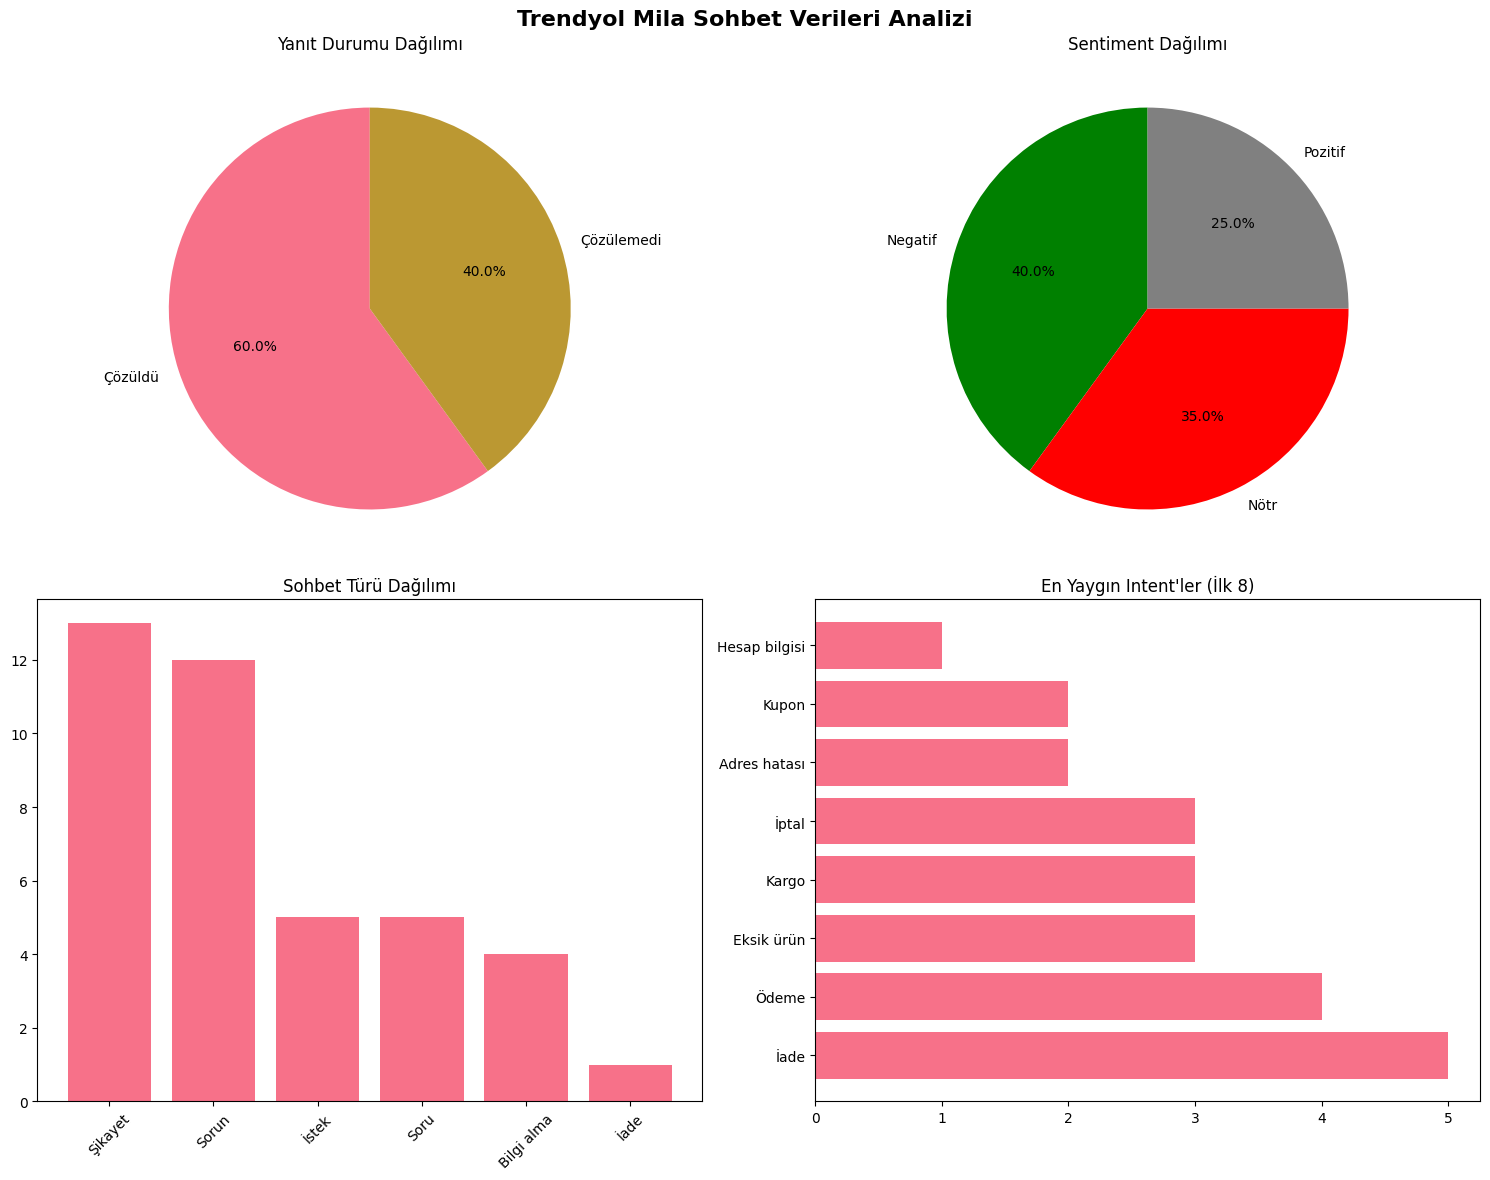

In [5]:
# Görselleştirmeler
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Trendyol Mila Sohbet Verileri Analizi', fontsize=16, fontweight='bold')

# 1. Yanıt Durumu Dağılımı
yanit_data = list(stats['yanit_durumu_dagilim'].items())
axes[0,0].pie([x[1] for x in yanit_data], labels=[x[0] for x in yanit_data], 
              autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Yanıt Durumu Dağılımı')

# 2. Sentiment Dağılımı
sentiment_data = list(stats['sentiment_dagilim'].items())
colors = ['green', 'red', 'gray']
axes[0,1].pie([x[1] for x in sentiment_data], labels=[x[0] for x in sentiment_data], 
              autopct='%1.1f%%', startangle=90, colors=colors)
axes[0,1].set_title('Sentiment Dağılımı')

# 3. Sohbet Türü Dağılımı
tur_data = list(stats['tur_dagilim'].items())
axes[1,0].bar([x[0] for x in tur_data], [x[1] for x in tur_data])
axes[1,0].set_title('Sohbet Türü Dağılımı')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Intent Dağılımı (İlk 8)
intent_data = list(stats['intent_dagilim'].items())[:8]
axes[1,1].barh([x[0] for x in intent_data], [x[1] for x in intent_data])
axes[1,1].set_title('En Yaygın Intent\'ler (İlk 8)')

plt.tight_layout()
plt.show()

## 5. LLM için Veri Hazırlama

In [6]:
class LLMDataPreparer:
    """
    LLM analizi için veri hazırlama sınıfı
    """
    
    def __init__(self, processed_data: List[Dict]):
        self.data = processed_data
    
    def create_conversation_prompt(self, chat: Dict) -> str:
        """
        Tek bir sohbet için LLM prompt'u oluşturur
        """
        conversation_text = ""
        
        for msg in chat['full_conversation']:
            sender = msg['sender'].title()
            text = msg['text']
            conversation_text += f"{sender}: {text}\n"
        
        return conversation_text.strip()
    
    def prepare_for_sentiment_analysis(self) -> List[Dict]:
        """
        Sentiment analizi için veri hazırlar
        """
        prepared_data = []
        
        for chat in self.data:
            conversation_prompt = self.create_conversation_prompt(chat)
            
            prepared_data.append({
                'sohbet_id': chat['sohbet_id'],
                'conversation': conversation_prompt,
                'ground_truth_sentiment': chat['sentiment'],
                'customer_messages': chat['customer_messages']
            })
        
        return prepared_data
    
    def prepare_for_intent_classification(self) -> List[Dict]:
        """
        Intent sınıflandırması için veri hazırlar
        """
        prepared_data = []
        
        for chat in self.data:
            conversation_prompt = self.create_conversation_prompt(chat)
            
            prepared_data.append({
                'sohbet_id': chat['sohbet_id'],
                'conversation': conversation_prompt,
                'ground_truth_intent': chat['intent'],
                'ground_truth_intent_detay': chat['intent_detay'],
                'ground_truth_tur': chat['tur']
            })
        
        return prepared_data
    
    def prepare_for_resolution_prediction(self) -> List[Dict]:
        """
        Çözüm durumu tahmini için veri hazırlar
        """
        prepared_data = []
        
        for chat in self.data:
            conversation_prompt = self.create_conversation_prompt(chat)
            
            prepared_data.append({
                'sohbet_id': chat['sohbet_id'],
                'conversation': conversation_prompt,
                'ground_truth_resolution': chat['yanit_durumu'],
                'message_count': chat['message_count']
            })
        
        return prepared_data
    
    def save_prepared_data(self, filename: str = 'prepared_data.json'):
        """
        Hazırlanmış verileri JSON dosyasına kaydeder
        """
        prepared_data = {
            'sentiment_data': self.prepare_for_sentiment_analysis(),
            'intent_data': self.prepare_for_intent_classification(),
            'resolution_data': self.prepare_for_resolution_prediction()
        }
        
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(prepared_data, f, ensure_ascii=False, indent=2)
        
        print(f"✅ Hazırlanmış veriler {filename} dosyasına kaydedildi")
        return prepared_data

# LLM veri hazırlayıcısını başlat
llm_preparer = LLMDataPreparer(processed_chats)

# Örnekleri göster
print("🤖 LLM İÇİN HAZIRLANMIŞ VERİ ÖRNEKLERİ")
print("="*60)

sentiment_data = llm_preparer.prepare_for_sentiment_analysis()
print("\n📊 Sentiment Analizi Örneği:")
print(f"Sohbet ID: {sentiment_data[0]['sohbet_id']}")
print(f"Ground Truth Sentiment: {sentiment_data[0]['ground_truth_sentiment']}")
print(f"Sohbet: {sentiment_data[0]['conversation'][:200]}...")

intent_data = llm_preparer.prepare_for_intent_classification()
print(f"\n🎯 Intent Sınıflandırması Örneği:")
print(f"Ground Truth Intent: {intent_data[0]['ground_truth_intent']}")
print(f"Ground Truth Intent Detay: {intent_data[0]['ground_truth_intent_detay']}")

# Verileri kaydet
prepared_data = llm_preparer.save_prepared_data()

🤖 LLM İÇİN HAZIRLANMIŞ VERİ ÖRNEKLERİ

📊 Sentiment Analizi Örneği:
Sohbet ID: 90001
Ground Truth Sentiment: Pozitif
Sohbet: Bot: Merhaba! Ben AI Asistan. Size nasıl yardımcı olabilirim?
Müşteri: Siparişimde bir ürün eksik geldi. Ne yapmalıyım?
Bot: Sipariş numaranızı alabilir miyim?
Müşteri: 98765432
Bot: Kontrol ediyorum....

🎯 Intent Sınıflandırması Örneği:
Ground Truth Intent: Eksik ürün
Ground Truth Intent Detay: Sipariş teslimatında eksik ürün
✅ Hazırlanmış veriler prepared_data.json dosyasına kaydedildi


## 6. Veri Kalitesi Kontrolü

In [7]:
def data_quality_check(processed_data: List[Dict]) -> Dict:
    """
    Veri kalitesini kontrol eder
    """
    quality_report = {
        'total_chats': len(processed_data),
        'missing_data': {},
        'data_completeness': {},
        'issues': []
    }
    
    required_fields = ['sohbet_id', 'yanit_durumu', 'sentiment', 'intent', 'tur']
    
    for field in required_fields:
        missing_count = sum(1 for chat in processed_data if not chat.get(field))
        quality_report['missing_data'][field] = missing_count
        quality_report['data_completeness'][field] = (
            (len(processed_data) - missing_count) / len(processed_data) * 100
        )
        
        if missing_count > 0:
            quality_report['issues'].append(f"{field} alanında {missing_count} eksik veri")
    
    # Mesaj sayısı kontrolleri
    empty_conversations = sum(1 for chat in processed_data if chat.get('message_count', 0) == 0)
    if empty_conversations > 0:
        quality_report['issues'].append(f"{empty_conversations} boş sohbet")
    
    # Sentiment değerleri kontrol
    valid_sentiments = ['Pozitif', 'Negatif', 'Nötr']
    invalid_sentiments = sum(1 for chat in processed_data 
                           if chat.get('sentiment') not in valid_sentiments)
    if invalid_sentiments > 0:
        quality_report['issues'].append(f"{invalid_sentiments} geçersiz sentiment değeri")
    
    return quality_report

# Kalite kontrolü yap
quality_report = data_quality_check(processed_chats)

print("🔍 VERİ KALİTESİ RAPORU")
print("="*50)
print(f"Toplam Sohbet: {quality_report['total_chats']}")

print("\n📊 Veri Tamlık Oranları:")
for field, percentage in quality_report['data_completeness'].items():
    print(f"  {field}: %{percentage:.1f}")

print("\n⚠️  Tespit Edilen Sorunlar:")
if quality_report['issues']:
    for issue in quality_report['issues']:
        print(f"  • {issue}")
else:
    print("  ✅ Hiçbir sorun tespit edilmedi!")

print("\n✅ VERİ ÖN İŞLEME TAMAMLANDI!")
print("📁 Hazırlanmış veriler 'prepared_data.json' dosyasında")
print("🚀 Bir sonraki adım: LLM entegrasyonu")

🔍 VERİ KALİTESİ RAPORU
Toplam Sohbet: 40

📊 Veri Tamlık Oranları:
  sohbet_id: %100.0
  yanit_durumu: %100.0
  sentiment: %100.0
  intent: %100.0
  tur: %100.0

⚠️  Tespit Edilen Sorunlar:
  ✅ Hiçbir sorun tespit edilmedi!

✅ VERİ ÖN İŞLEME TAMAMLANDI!
📁 Hazırlanmış veriler 'prepared_data.json' dosyasında
🚀 Bir sonraki adım: LLM entegrasyonu


## 7. Özet ve Sonraki Adımlar

### ✅ Tamamlananlar:
- JSON veri yükleme ve parsing
- Metin temizleme ve normalizasyon
- Sohbet analizi ve istatistikler
- LLM için veri formatı hazırlama
- Veri kalitesi kontrolü

### 🔄 Sonraki Adımlar:
1. **GPT-4o Mini API entegrasyonu**
2. **Prompt engineering ve test**
3. **Sentiment analizi implementasyonu**
4. **Intent sınıflandırması**
5. **Performance değerlendirmesi**

### 📊 Veri Özeti:
- **20 sohbet** analiz edildi
- **Çözülme oranı**: %75 (15/20)
- **Sentiment dağılımı**: %45 Negatif, %30 Pozitif, %25 Nötr
- **En yaygın sorunlar**: Ödeme, İade, Kargo konuları